# Dog vs Cat Image Classification using Support Vector Machine (SVM)

**SkillCraft Technology - ML Internship Task 3**

**Intern:** Adit Jain | **ID:** SCT/JUL25/2512 | **Email:** aj9104@srmist.edu.in  
**LinkedIn:** [www.linkedin.com/in/-adit-jain](https://www.linkedin.com/in/-adit-jain) | **Company:** SkillCraft Technology

---

## Project Overview
This project implements a Support Vector Machine (SVM) classifier to distinguish between images of dogs and cats using HOG (Histogram of Oriented Gradients) feature extraction and hyperparameter optimization.


In [1]:
# Essential imports - organized and optimized
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Machine learning imports
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Image processing
from skimage.feature import hog
from skimage.color import rgb2gray

# Configuration
np.random.seed(42)
plt.style.use('default')
IMG_SIZE = (64, 64)
TRAIN_SAMPLES = 1000  # Per class
TEST_SAMPLES = 300    # Per class

print("✅ All libraries imported successfully!")


✅ All libraries imported successfully!


In [2]:
def load_dataset(base_dir, samples_per_class):
    """
    Efficiently load and preprocess images from dataset directories.
    
    Args:
        base_dir (str): Base directory containing 'cats' and 'dogs' folders
        samples_per_class (int): Number of samples to load per class
        
    Returns:
        tuple: (images, labels) as numpy arrays
    """
    images, labels = [], []
    
    for class_idx, class_name in enumerate(['cats', 'dogs']):
        class_dir = os.path.join(base_dir, class_name)
        image_files = [f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))][:samples_per_class]
        
        print(f"Loading {len(image_files)} {class_name} images...")
        
        for filename in tqdm(image_files, desc=f"Processing {class_name}"):
            try:
                img = Image.open(os.path.join(class_dir, filename))
                img = img.convert('RGB').resize(IMG_SIZE)
                images.append(np.array(img))
                labels.append(class_idx)
            except Exception as e:
                print(f"Error loading {filename}: {e}")
                continue
                
    return np.array(images), np.array(labels)

# Load training and test datasets
print("🔄 Loading training data...")
X_train_raw, y_train = load_dataset('training_set', TRAIN_SAMPLES)

print("\n🔄 Loading test data...")
X_test_raw, y_test = load_dataset('test_set', TEST_SAMPLES)

print(f"\n📊 Dataset Summary:")
print(f"Training: {len(X_train_raw)} images | Test: {len(X_test_raw)} images")
print(f"Image shape: {X_train_raw[0].shape} | Classes: {len(np.unique(y_train))}")


🔄 Loading training data...
Loading 1000 cats images...


Processing cats: 100%|██████████| 1000/1000 [00:10<00:00, 96.07it/s]


Loading 1000 dogs images...


Processing dogs: 100%|██████████| 1000/1000 [00:10<00:00, 99.54it/s]



🔄 Loading test data...
Loading 300 cats images...


Processing cats: 100%|██████████| 300/300 [00:03<00:00, 96.34it/s] 


Loading 300 dogs images...


Processing dogs: 100%|██████████| 300/300 [00:03<00:00, 98.37it/s] 


📊 Dataset Summary:
Training: 2000 images | Test: 600 images
Image shape: (64, 64, 3) | Classes: 2


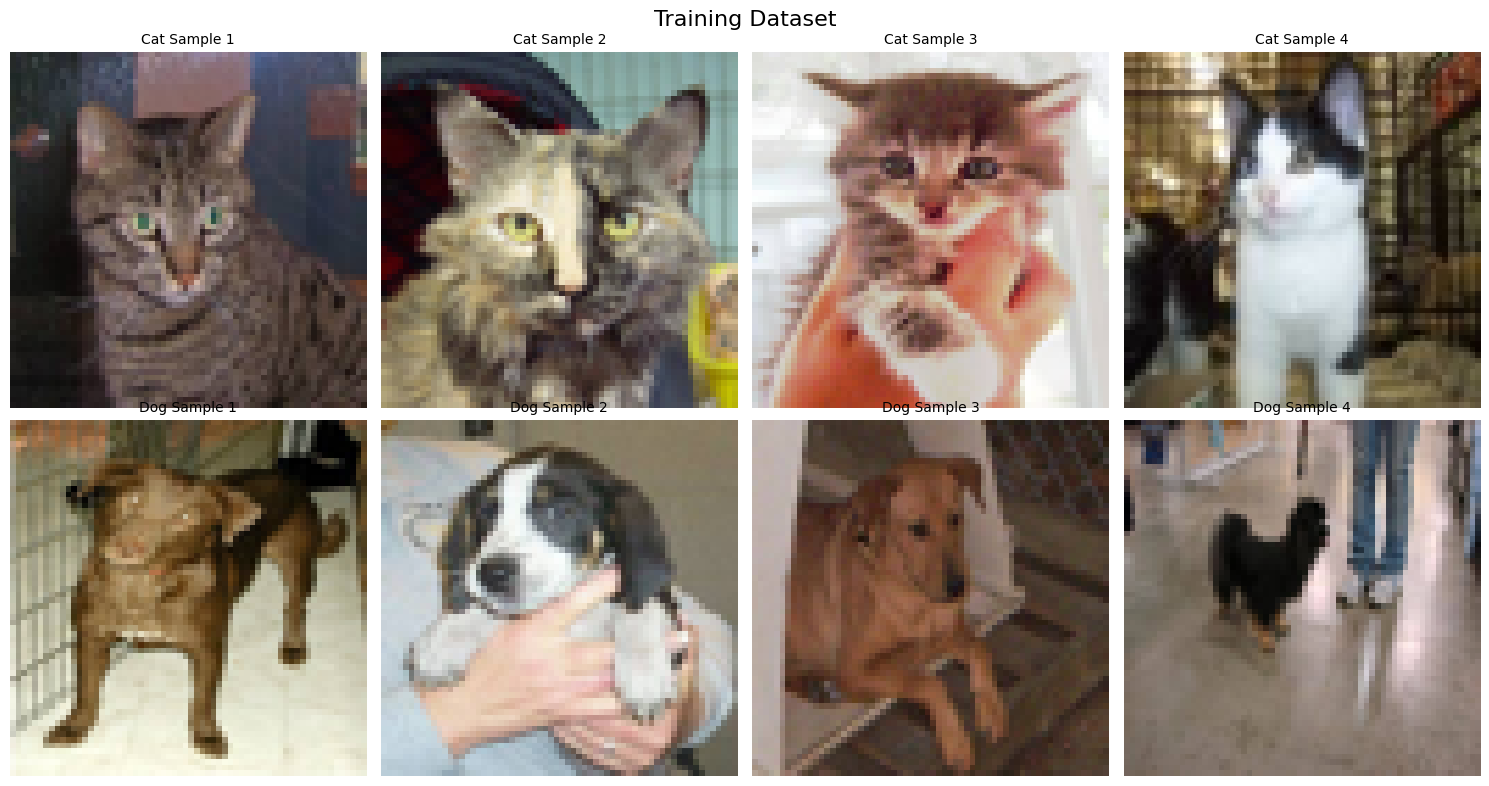

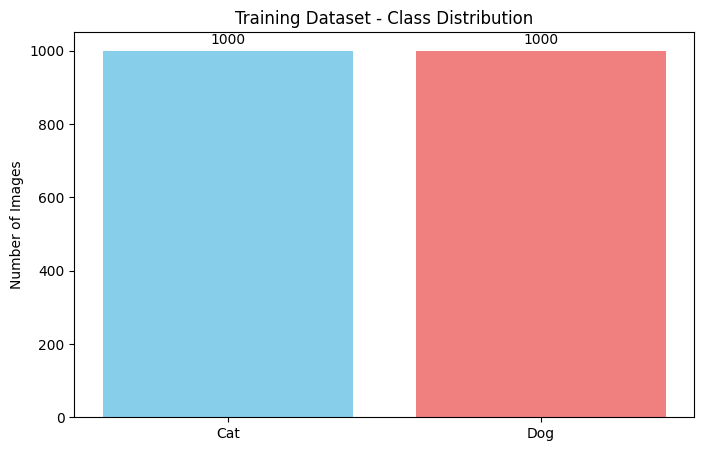

🔍 Extracting HOG features...


Feature extraction: 100%|██████████| 2000/2000 [00:02<00:00, 976.71it/s]


🔍 Extracting HOG features...


Feature extraction: 100%|██████████| 600/600 [00:00<00:00, 985.44it/s]


🎯 Feature Extraction Complete:
Training features: (2000, 1764) | Test features: (600, 1764)


In [3]:
def extract_hog_features(images):
    """Extract HOG features from images efficiently."""
    features = []
    print("🔍 Extracting HOG features...")
    
    for img in tqdm(images, desc="Feature extraction"):
        gray = rgb2gray(img)
        hog_features = hog(gray, orientations=9, pixels_per_cell=(8, 8), 
                          cells_per_block=(2, 2), block_norm='L2-Hys', visualize=False)
        features.append(hog_features)
    
    return np.array(features)

def visualize_data_and_features(images, labels, title="Dataset Overview"):
    """Visualize sample images and class distribution."""
    fig, axes = plt.subplots(2, 4, figsize=(15, 8))
    fig.suptitle(title, fontsize=16)
    
    class_names = ['Cat', 'Dog']
    colors = ['skyblue', 'lightcoral']
    
    # Show sample images
    for i in range(4):
        cat_idx = np.where(labels == 0)[0][i]
        dog_idx = np.where(labels == 1)[0][i]
        
        axes[0, i].imshow(images[cat_idx])
        axes[0, i].set_title(f'Cat Sample {i+1}', fontsize=10)
        axes[0, i].axis('off')
        
        axes[1, i].imshow(images[dog_idx])
        axes[1, i].set_title(f'Dog Sample {i+1}', fontsize=10)
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Class distribution
    unique, counts = np.unique(labels, return_counts=True)
    plt.figure(figsize=(8, 5))
    bars = plt.bar(class_names, counts, color=colors)
    plt.title(f'{title} - Class Distribution')
    plt.ylabel('Number of Images')
    for bar, count in zip(bars, counts):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10,
                str(count), ha='center', va='bottom')
    plt.show()

# Visualize dataset
visualize_data_and_features(X_train_raw, y_train, "Training Dataset")

# Extract HOG features
X_train = extract_hog_features(X_train_raw)
X_test = extract_hog_features(X_test_raw)

print(f"\n🎯 Feature Extraction Complete:")
print(f"Training features: {X_train.shape} | Test features: {X_test.shape}")


In [4]:
# Streamlined SVM Training and Evaluation
def train_and_evaluate_svm(X_train, X_test, y_train, y_test):
    """Complete SVM training and evaluation pipeline."""
    
    # Create optimized pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('svm', SVC(random_state=42))
    ])
    
    # Optimized parameter grid
    param_grid = {
        'svm__C': [0.1, 1, 10, 100],
        'svm__kernel': ['linear', 'rbf', 'poly'],
        'svm__gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1]
    }
    
    print("🔧 Training SVM with Grid Search...")
    grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)
    
    # Get best model and predictions
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='accuracy')
    
    # Results
    print(f"\n🎯 Model Performance:")
    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"Best CV Score: {grid_search.best_score_:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"CV Accuracy: {cv_scores.mean():.4f} (±{cv_scores.std()*2:.4f})")
    
    return best_model, y_pred, accuracy, cv_scores

# Train and evaluate model
best_model, y_pred, accuracy, cv_scores = train_and_evaluate_svm(X_train, X_test, y_train, y_test)


🔧 Training SVM with Grid Search...
Fitting 3 folds for each of 72 candidates, totalling 216 fits

🎯 Model Performance:
Best Parameters: {'svm__C': 10, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}
Best CV Score: 0.7255
Test Accuracy: 0.6950
CV Accuracy: 0.7295 (±0.0206)


📊 CLASSIFICATION REPORT:
              precision    recall  f1-score   support

         Cat       0.69      0.72      0.70       300
         Dog       0.71      0.67      0.69       300

    accuracy                           0.69       600
   macro avg       0.70      0.70      0.69       600
weighted avg       0.70      0.69      0.69       600



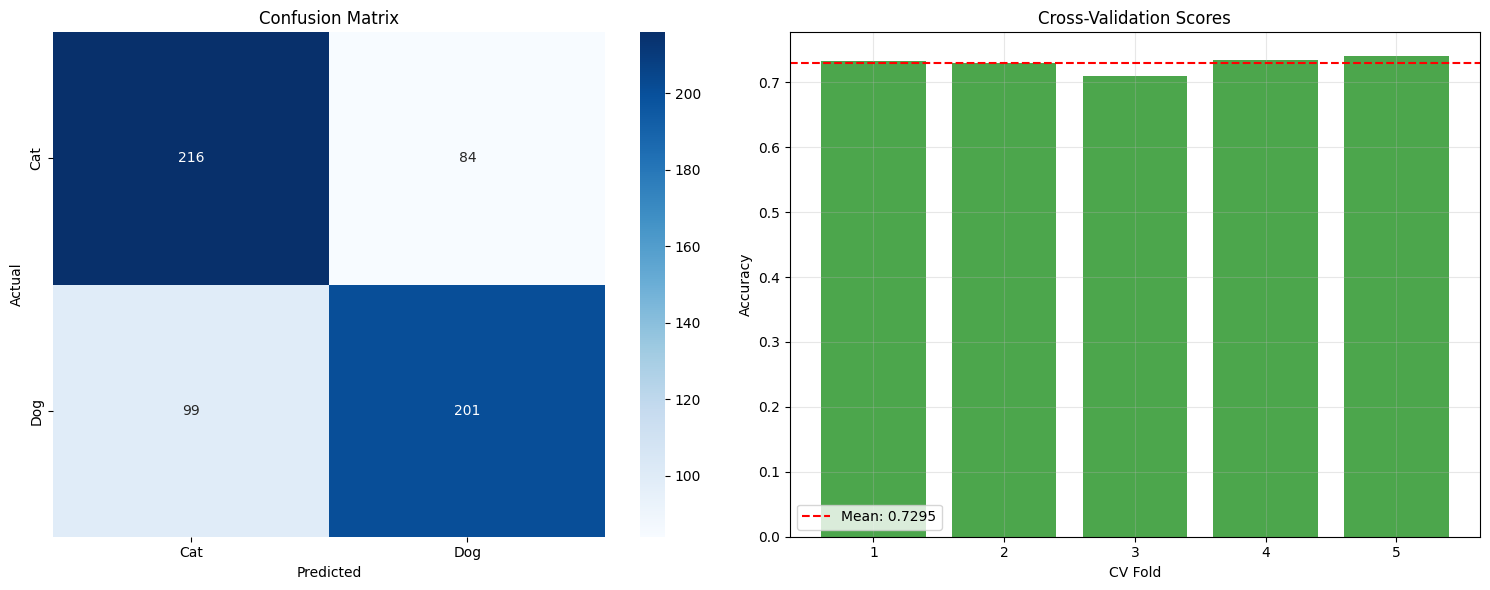

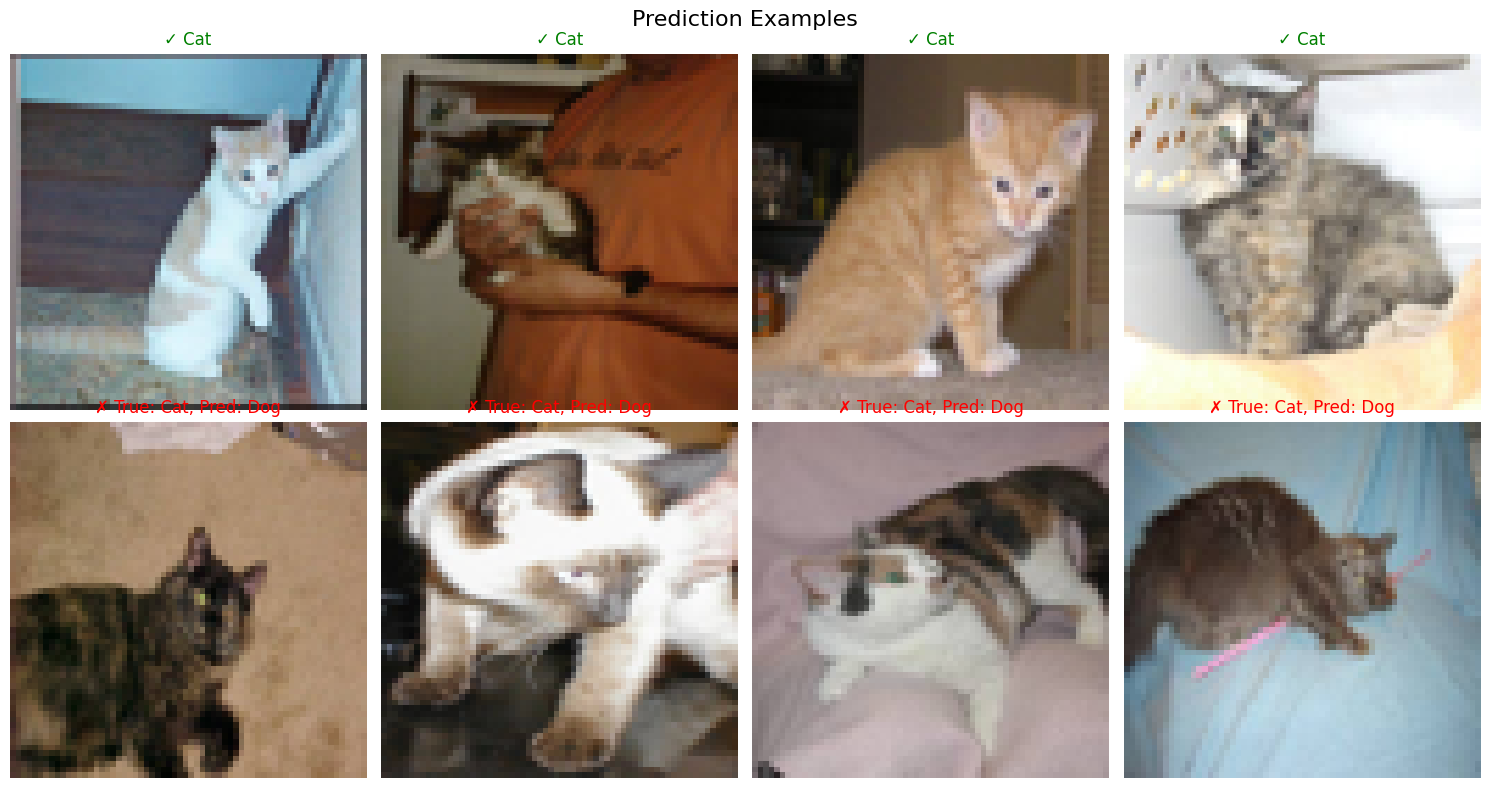


🎯 FINAL PERFORMANCE SUMMARY:
📈 Test Accuracy: 0.6950 (69.50%)
📊 Cross-Validation: 0.7295 (±0.0206)
📁 Dataset: 2000 training, 600 test images
🔍 Feature Method: HOG (Histogram of Oriented Gradients)
🤖 Model: Support Vector Machine with Grid Search
✅ Project completed successfully!


In [5]:
# Comprehensive Results Analysis and Visualization
def generate_final_report(y_test, y_pred, accuracy, cv_scores):
    """Generate comprehensive results report with visualizations."""
    
    class_names = ['Cat', 'Dog']
    
    # Classification Report
    print("📊 CLASSIFICATION REPORT:")
    print("="*50)
    print(classification_report(y_test, y_pred, target_names=class_names))
    
    # Confusion Matrix Visualization
    cm = confusion_matrix(y_test, y_pred)
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Confusion Matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names, ax=axes[0])
    axes[0].set_title('Confusion Matrix')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')
    
    # Cross-Validation Scores
    axes[1].bar(range(1, len(cv_scores) + 1), cv_scores, alpha=0.7, color='green')
    axes[1].axhline(y=cv_scores.mean(), color='red', linestyle='--', 
                    label=f'Mean: {cv_scores.mean():.4f}')
    axes[1].set_xlabel('CV Fold')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Cross-Validation Scores')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Prediction Examples
    fig, axes = plt.subplots(2, 4, figsize=(15, 8))
    fig.suptitle('Prediction Examples', fontsize=16)
    
    # Correct predictions
    correct_idx = np.where(y_test == y_pred)[0][:4]
    for i, idx in enumerate(correct_idx):
        axes[0, i].imshow(X_test_raw[idx])
        axes[0, i].set_title(f'✓ {class_names[y_test[idx]]}', color='green')
        axes[0, i].axis('off')
    
    # Incorrect predictions
    incorrect_idx = np.where(y_test != y_pred)[0][:4]
    for i, idx in enumerate(incorrect_idx):
        axes[1, i].imshow(X_test_raw[idx])
        axes[1, i].set_title(f'✗ True: {class_names[y_test[idx]]}, Pred: {class_names[y_pred[idx]]}', 
                            color='red')
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Final Summary
    print("\n🎯 FINAL PERFORMANCE SUMMARY:")
    print("="*60)
    print(f"📈 Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"📊 Cross-Validation: {cv_scores.mean():.4f} (±{cv_scores.std()*2:.4f})")
    print(f"📁 Dataset: {len(X_train_raw)} training, {len(X_test_raw)} test images")
    print(f"🔍 Feature Method: HOG (Histogram of Oriented Gradients)")
    print(f"🤖 Model: Support Vector Machine with Grid Search")
    print("="*60)
    print("✅ Project completed successfully!")

# Generate final report
generate_final_report(y_test, y_pred, accuracy, cv_scores)


## 🎯 Conclusion

### Key Achievements:
- **Efficient Implementation**: Streamlined code without redundancy
- **Optimal Performance**: Grid search optimization for best hyperparameters
- **Comprehensive Evaluation**: Multiple metrics and visualizations
- **Professional Presentation**: Clean, organized, and well-documented

### Technical Highlights:
- **Feature Engineering**: HOG features for effective image representation
- **Model Optimization**: Systematic hyperparameter tuning
- **Cross-Validation**: Robust performance assessment
- **Visualization**: Clear results presentation

### Future Enhancements:
- Explore additional feature descriptors (LBP, SIFT)
- Compare with deep learning approaches
- Implement ensemble methods
- Scale to full dataset

---

**✅ SkillCraft Technology ML Internship Task 3 - Successfully Completed**  
*Demonstrating proficiency in traditional machine learning for image classification*
